## Import library

In [1]:
import os
import cv2
import time
import mmcv
import heapq
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pycocotools.mask as maskUtils
from tqdm import tqdm
from mmdet.apis import inference_detector, init_detector

## Define function (Plot segmentation)

In [2]:
def show_result(img, result, class_names, score_thr=0.8):
    bbox_result, segm_result = result

    ###########################################
    # for one class, only keep one bbox and one segm with highest confidence
    new_bbox_result = []
    new_segm_result = []
    for bbox, segm in zip(bbox_result, segm_result):
        if len(bbox) <= 1:
            new_bbox_result.append(bbox)
            new_segm_result.append(segm)
            continue
        max_ind = np.argmax(bbox[:, -1])
        new_segm_result.append(np.asarray([segm[max_ind]]))
        new_bbox_result.append(np.asarray([bbox[max_ind]]))

    bbox_result = new_bbox_result
    segm_result = new_segm_result
    #########################################

    bboxes = np.vstack(bbox_result)
    labels = [np.full(bbox.shape[0], i, dtype=np.int32) for i, bbox in enumerate(bbox_result)]
    labels = np.concatenate(labels)

    label_candidate = [class_names[i] for i in labels]

    output_segmentation = {}
    if segm_result is not None:
        segms = mmcv.concat_list(segm_result)
        inds = np.where(bboxes[:, -1] > score_thr)[0]
        np.random.seed(42)
        try:
            color_masks = [np.random.randint(0, 256, (1, 3), dtype=np.uint8) for _ in range(max(labels) + 1)]

            for i in inds:
                color_mask = color_masks[labels[i]]
                mask = maskUtils.decode(segms[i]).astype(np.bool)

                item = img.copy()
                item[~mask] = 0

                output_segmentation[label_candidate[i]] = item
        except:
            pass

    return output_segmentation

## Setting parameters

In [3]:
model_path = './mmfashion/checkpoint/segmentation.pth'
config_file_path = './mmfashion/mmdetection/configs/mmfashion/mask_rcnn_r50_fpn_1x.py'
input_path = './EC_dataset/img/try_on/'

## List testing image

In [4]:
input_img_list = [file for file in os.listdir(input_path) if ('.jpg' in file) or ('.jpeg' in file) or ('.png' in file)]
if input_img_list == []:
    print('Can not find any image in folder "inputs"...')
print(f'Number of data : {len(input_img_list)}')

Number of data : 321


## ---------------------------------------------------- Segmentator ----------------------------------------------------

In [5]:
segmentator = init_detector(config_file_path, model_path, device='cuda:0')
segmentator.eval()
print('Class : \n', segmentator.CLASSES)

Class : 
 ('top', 'skirt', 'leggings', 'dress', 'outer', 'pants', 'bag', 'neckwear', 'headwear', 'eyeglass', 'belt', 'footwear', 'hair', 'skin', 'face')


In [6]:
segmentation_top = []
segmentation_bottom = []
segmentation_outer = []
save_seg_top = f'./segmentation_data/EC_top_segmentation.npy'
save_seg_bottom = f'./segmentation_data/EC_bottom_segmentation.npy'
save_seg_outer = f'./segmentation_data/EC_outer_segmentation.npy'

for file in tqdm(input_img_list):
    img_path = os.path.join(input_path, file)
    
    # Read image
    img = cv2.imread(img_path)

    # Inference
    result = inference_detector(segmentator, img)

    # Draw bbox and segmentarion mask
    output_segmentation = show_result(img, result, segmentator.CLASSES, score_thr=0.8)

    for cate, seg_item in zip(output_segmentation.keys(), output_segmentation.values()):
        if cate == 'top':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
            segmentation_top.append(plot_item)
        if cate == 'skirt' or cate == 'leggings' or cate == 'pants':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
            segmentation_bottom.append(plot_item)
        if cate == 'outer':
            plot_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
            segmentation_outer.append(plot_item)
        
np.save(save_seg_top, segmentation_top)
np.save(save_seg_bottom, segmentation_bottom)
np.save(save_seg_outer, segmentation_outer)

100%|██████████| 321/321 [00:37<00:00,  8.57it/s]


## ------------------------------------------------- Feature Extractor -------------------------------------------------

In [7]:
segmentation_top = np.load(f'./segmentation_data/EC_top_segmentation.npy', allow_pickle=True)
segmentation_bottom = np.load(f'./segmentation_data/EC_bottom_segmentation.npy', allow_pickle=True)
segmentation_outer = np.load(f'./segmentation_data/EC_outer_segmentation.npy', allow_pickle=True)

In [8]:
''' For debug '''
# for top in segmentation_top[:5]:
#     plt.figure(figsize=(6, 6))
#     plt.axis('off')
#     plt.imshow(top)
#     plt.show()
pass

In [9]:
from __future__ import division
import torch
import torchvision.transforms as transforms

from PIL import Image

from mmcv import Config
from mmcv.runner import load_checkpoint

from mmfashion.core import AttrPredictor, CatePredictor
from mmfashion.models import build_predictor

In [10]:
def get_img_tensor(img, get_size=False):
    img = Image.fromarray(img)  
#     original_w, original_h = img.size

#     img_size = (224, 224)  # crop image to (224, 224)
#     img.thumbnail(img_size, Image.ANTIALIAS)
#     img = img.convert('RGB')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
#         transforms.RandomResizedCrop(img_size[0]),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])
    img_tensor = transform(img)
    img_tensor = torch.unsqueeze(img_tensor, 0)
    
    img_tensor = img_tensor.cuda()
    if get_size:
        return img_tensor, original_w, original_w
    else:
        return img_tensor

In [11]:
checkpoint_path = './mmfashion/checkpoint/cate_att_pre_fine_resnet_global.pth'
cfg = Config.fromfile('./mmfashion/configs/category_attribute_predict/global_predictor_resnet.py')

# checkpoint_path = './mmfashion/checkpoint/cate_att_pre_fine_vgg_global.pth'
# cfg = Config.fromfile('./mmfashion/configs/category_attribute_predict/global_predictor_vgg.py')

# checkpoint_path = './mmfashion/checkpoint/cate_att_pre_fine_resnet_land.pth'
# cfg = Config.fromfile('./mmfashion/configs/category_attribute_predict/global_predictor_resnet.py')

feature_extractor = build_predictor(cfg.model)
feature_extractor.cuda()

load_checkpoint(feature_extractor, checkpoint_path, map_location='cpu')
print('model loaded from {}'.format(checkpoint_path))

landmark_tensor = torch.zeros(8)
landmark_tensor = landmark_tensor.cuda()
# feature_extractor.attr_predictor = torch.nn.Flatten()
# feature_extractor.cate_predictor = torch.nn.Flatten()
# feature_extractor.eval()

feature_extractor = torch.nn.Sequential(*list(feature_extractor.children())[:-2])
feature_extractor.eval()
track_running_stats=True
print(feature_extractor)

print('Finished loading model !')

pretrained model /home/jovyan/at101-group14/mmfashion/checkpoint/resnet50.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

The model and loaded state dict do not match exactly

unexpected key in source state_dict: roi_pool.linear.0.weight, roi_pool.linear.0.bias, concat.fc_fusion.weight, concat.fc_fusion.bias

model loaded from ./mmfashion/checkpoint/cate_att_pre_fine_resnet_global.pth
Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [12]:
''' For debug '''
# debug_img = cv2.imread('./demo_image/test0000.jpeg')
# # debug_img = np.zeros((620, 445, 3)).astype('uint8')
# debug_tensor = get_img_tensor(debug_img)
# # feature_vector = feature_extractor(debug_tensor, attr=None, landmark=landmark_tensor, return_loss=False)
# feature_vector = feature_extractor(debug_tensor)
# feature_vector_numpy = feature_vector[0].squeeze().cpu().detach().numpy() 
# feature_vector_numpy

' For debug '

In [13]:
feature_vector_top = []
feature_vector_bottom = []
feature_vector_outer = []
save_vec_top = f'./segmentation_data/EC_top_feature.npy'
save_vec_bottom = f'./segmentation_data/EC_bottom_feature.npy'
save_vec_outer = f'./segmentation_data/EC_outer_feature.npy'

print('Encoding top ...')
time.sleep(1)
for top in tqdm(segmentation_top):
    img_tensor = get_img_tensor(top)
    # feature_vector = feature_extractor(img_tensor, attr=None, landmark=landmark_tensor, return_loss=False)
    feature_vector = feature_extractor(img_tensor)
    feature_vector_numpy = feature_vector[0].squeeze().cpu().detach().numpy() 
    feature_vector_top.append(feature_vector_numpy)
    
print('Encoding bottom ...')
time.sleep(1)
for bottom in tqdm(segmentation_bottom):
    img_tensor = get_img_tensor(bottom)
    # feature_vector = feature_extractor(img_tensor, attr=None, landmark=landmark_tensor, return_loss=False)
    feature_vector = feature_extractor(img_tensor)
    feature_vector_numpy = feature_vector[0].squeeze().cpu().detach().numpy() 
    feature_vector_bottom.append(feature_vector_numpy)

print('Encoding outer ...')
time.sleep(1)
for outer in tqdm(segmentation_outer):
    img_tensor = get_img_tensor(outer)
    # feature_vector = feature_extractor(img_tensor, attr=None, landmark=landmark_tensor, return_loss=False)
    feature_vector = feature_extractor(img_tensor)
    feature_vector_numpy = feature_vector[0].squeeze().cpu().detach().numpy() 
    feature_vector_outer.append(feature_vector_numpy)

np.save(save_vec_top, feature_vector_top)
np.save(save_vec_bottom, feature_vector_bottom)
np.save(save_vec_outer, feature_vector_outer)

Encoding top ...


100%|██████████| 275/275 [00:04<00:00, 67.18it/s]


Encoding bottom ...


100%|██████████| 298/298 [00:04<00:00, 67.96it/s]


Encoding outer ...


100%|██████████| 24/24 [00:00<00:00, 67.05it/s]


## Inference

In [14]:
def euclidean_distance(a, b):
    dist = np.linalg.norm(a - b)
    return dist

## Segmentator

In [15]:
input_img = cv2.imread('./p300003.jpeg') ####input image
cate_seg = {}

result = inference_detector(segmentator, input_img)

# Draw bbox and segmentarion mask
segmentation = show_result(input_img, result, segmentator.CLASSES, score_thr=0.9)

for cate, seg_item in zip(segmentation.keys(), segmentation.values()):
    if cate == 'top':
        seg_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
        cate_seg['top'] = seg_item
    if cate == 'skirt' or cate == 'leggings' or cate == 'pants':
        seg_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
        cate_seg['bottom'] = seg_item
    if cate == 'outer':
        seg_item = cv2.cvtColor(seg_item, cv2.COLOR_BGR2RGB)
        cate_seg['outer'] = seg_item
        
    #print(seg_item)

In [16]:
#print(cate_seg)

## Feature Extractor

Your input image !
Category : top


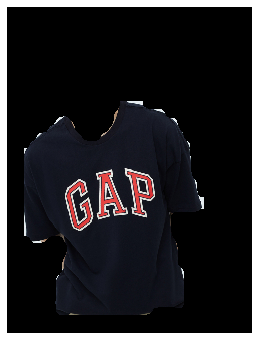

Find similar item !


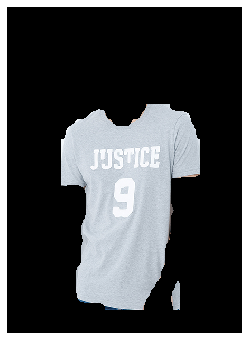

Find similar item !


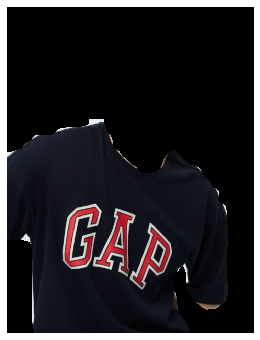

Find similar item !


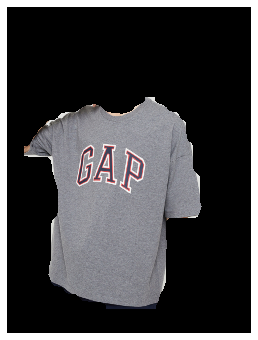

Find similar item !


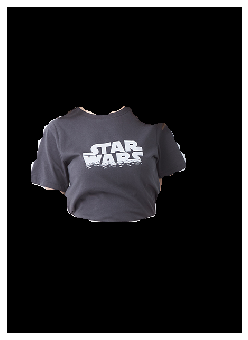

Find similar item !


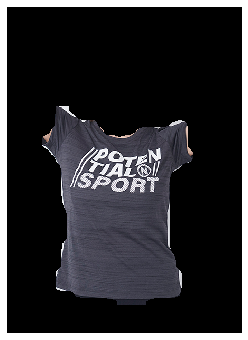

Your input image !
Category : bottom


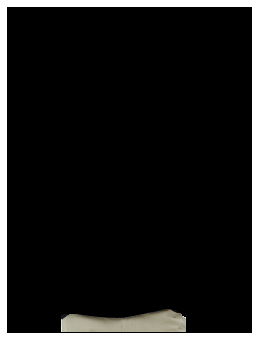

Find similar item !


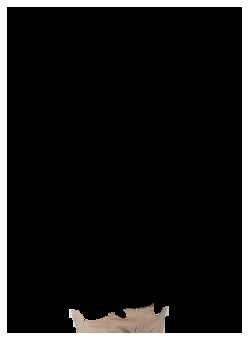

Find similar item !


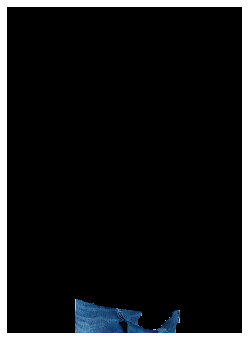

Find similar item !


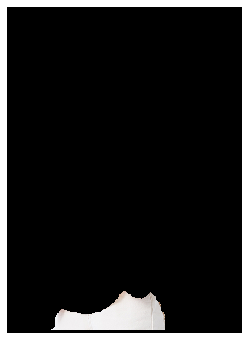

Find similar item !


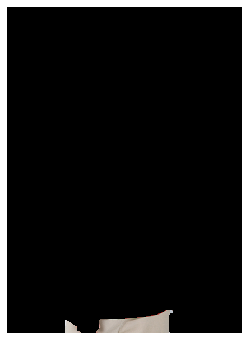

Find similar item !


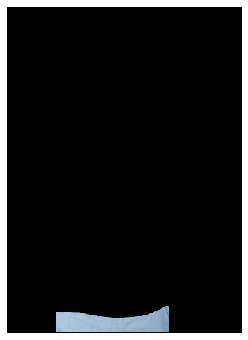

In [17]:
segmentation_top = np.load(f'./segmentation_data/EC_top_segmentation.npy', allow_pickle=True)
segmentation_bottom = np.load(f'./segmentation_data/EC_bottom_segmentation.npy', allow_pickle=True)
segmentation_outer = np.load(f'./segmentation_data/EC_outer_segmentation.npy', allow_pickle=True)

feature_vector_top = np.load(f'./segmentation_data/EC_top_feature.npy', allow_pickle=True)
feature_vector_bottom = np.load(f'./segmentation_data/EC_bottom_feature.npy', allow_pickle=True)
feature_vector_outer = np.load(f'./segmentation_data/EC_outer_feature.npy', allow_pickle=True)
dis_list = []

for cate, seg_item in zip(cate_seg.keys(), cate_seg.values()):   
    print('Your input image !')
    print(f'Category : {cate}')
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(seg_item)
    plt.show()
    
    ''' Feature extraction '''
    img_tensor = get_img_tensor(seg_item)
    # feature_vector = feature_extractor(img_tensor, attr=None, landmark=landmark_tensor, return_loss=False)
    feature_vector = feature_extractor(img_tensor)
    feature_vector_numpy = feature_vector[0].squeeze().cpu().detach().numpy() 
    
    if cate == 'top':
        dis_list = []
        for i in feature_vector_top:
            dis = euclidean_distance(feature_vector_numpy, i)
            dis_list.append(dis)
            
        top_5_index= list(map(dis_list.index, heapq.nsmallest(5, dis_list)))
        for ind in top_5_index:
            if dis_list[ind] < 10:
                print('Find similar item !')
                plt.figure(figsize=(6, 6))
                plt.axis('off')
                plt.imshow(segmentation_top[ind])
                plt.show()
            else:
                print('Can not find similar item in database')
            
            
            
    elif cate == 'bottom':
        dis_list = []
        for i in feature_vector_bottom:
            dis = euclidean_distance(feature_vector_numpy, i)
            dis_list.append(dis)
        
        top_5_index= list(map(dis_list.index, heapq.nsmallest(5, dis_list)))
        for ind in (top_5_index):
            if dis_list[ind] < 10:
                print('Find similar item !')
                plt.figure(figsize=(6, 6))
                plt.axis('off')
                plt.imshow(segmentation_bottom[ind])
                plt.show()
            else:
                print('Can not find similar item in database')
        
        
        
    elif cate == 'outer':
        dis_list = []
        for i in feature_vector_outer:
            dis = euclidean_distance(feature_vector_numpy, i)
            dis_list.append(dis)
            
        top_5_index= list(map(dis_list.index, heapq.nsmallest(5, dis_list)))
        for ind in (top_5_index):
            if dis_list[ind] < 10:
                print('Find similar item !')
                plt.figure(figsize=(6, 6))
                plt.axis('off')
                plt.imshow(segmentation_outer[ind])
                plt.show()
        else:
            print('Can not find similar item in database')